# 1.0 Introduction

In this notebook we will analyze the relationship between technical and educational features with and the compensation level of data scientists professionals. As we are alreadtying doing along other notebooks from this project, we will be using data from the 2020 Stack Overflow Survey.

All the imports used are normally distributed into a standard conda installation. A requirements.txt file is available in the root of the repository in order to a easy installation of all the dependencies needed for a correct execution of this, and all the others notebooks from the repository.

This notebook is divided into three parts. First this introduction with declared imports and loading and filtering of the needed dataset. In the second part we do some descriptive analysis regarding compensation, educational and technological variables. Then, in the last part, we try three different ways to measure the relationship between compensation and educational and technological variables.


## 1.1 Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os
from statsmodels.stats.outliers_influence import variance_inflation_factor

sns.set(context='notebook', style='whitegrid', font_scale=1)
plot_palette = sns.color_palette()
tech_palette = plot_palette[0:4]
educ_palette = plot_palette[4:6]

## 1.2 Loading Data

Loading the data from the 2020 survey, setting `Respodent` id to be the index of the data frame. Removing missing observations of `ConvertedComp` (compensations converted to yearly U.S. dollars) and `DevType` (declared of type of developer, such as, back-end, front-end, full-stack, data scientists, etc.). Than selecting only those developers of the type **Data scientists or machine learning specialist**.

In [2]:
data_folder = 'data'
file_path = os.path.join(data_folder, '2020_data.zip')
df = pd.read_csv(file_path, index_col='Respondent')
df.shape

(64461, 60)

In [3]:
df.dropna(subset=['ConvertedComp', 'DevType'], inplace=True)
ds = df['DevType'].str.contains('Data scientist or machine learning specialist')
ds_df = df[ds].copy()
ds_df.shape

(2619, 60)

# 2.0 Descriptive Analysis

## 2.1 Compensations

In our dataset we have two variables that can be used to measure professionals compensations: `CompTotal` and `ConvertedComp`. Taking a look at some statistics from both variables, it can be seen that `CompTotal` has a much greater standard deviation. This is a result from the different measures of currency in wich `CompTotal` is being measured as well as different periodicity. `ConvertedComp` annualize the `CompTotal` and convert all values to US$. `ConvertedComp` will be used since it is a standardize varible and offers adequete measure for comparsion between different respondents with different characteristics of technological usage and educational level. At first, the only transformation that wie wil be doing in our variables is to divide then by 12 in order to achieve a monthly compensation.

In [4]:
ds_df[['CompTotal', 'ConvertedComp']].div(12).describe().round(2)

,CompTotal,ConvertedComp
count,2.619000e+03,2619.00
mean,3.181876e+145,10325.93
std,1.628362e+147,23288.35
min,0.000000e+00,0.00
25%,2.208330e+03,2158.50
50%,5.833330e+03,4833.33
75%,1.250000e+04,8733.88
max,8.333333e+148,166666.67


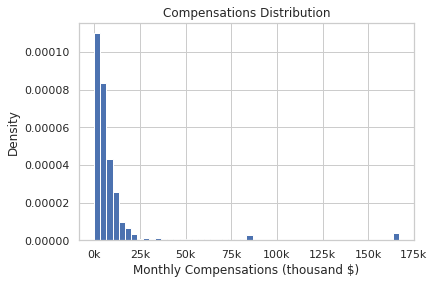

In [5]:
y = ds_df['ConvertedComp'].div(12)
ax = y.hist(bins=50, density=True)
ax.xaxis.set_major_formatter(lambda x, p: f'{x/1000:.0f}k')
plt.xlabel('Monthly Compensations (thousand $)')
plt.ylabel('Density')
plt.title('Compensations Distribution')
plt.show()

In [49]:
round((y < 25000).mean() * 100, 2)

94.19

The `ConvertedComp` has a very skwed distribution. The vast majority of respondents (94.19%) earn less than 25 thousand dollars per month. With a log transformation we can reduce the skweness of the distribution. With this transformation we also make it easer to find linear relationship with other variables. But before making this transformation we need to exclude observations with 0.

In [6]:
(y == 0).sum()

18

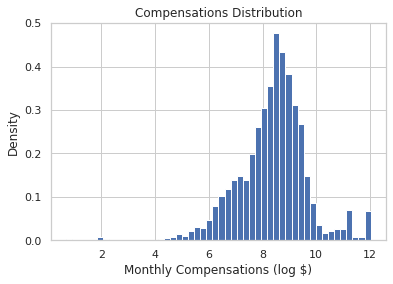

In [7]:
y.drop(y[y == 0].index, inplace=True)
log_y = y.apply(np.log).rename('LogConvertedComp')

log_y.hist(bins=50, density=True)
plt.xlabel('Monthly Compensations (log $)')
plt.ylabel('Density')
plt.title('Compensations Distribution')
plt.show()

## 2.2 Technological and Educational Data

Next we will analyze the distributions of our categorical variables related to technological and educational aspects of the respondents. First we will declare two functions that will one hot enconde all our selected variables and group then into a dataframe. To do it we will be using `pd.get_dummies` function from the `pandas` package.

Some of those categorical variables can have more than one option selected as an respondent answer. If we applied `pd.get_dummies` directly to those answers we would get as the number of features all the unique (if we considered only the technological variables, that value would be of 3.683 features). In order to correctly apply we first need to separate the answers by the options, transform those answers into dummify and then group it by respondents.

In [55]:
tech_types = ['Language', 'Platform', 'MiscTech', 'Database']
tech_vars = [tech + 'WorkedWith' for tech in tech_types]
ds_df[tech_vars].head()

,LanguageWorkedWith,PlatformWorkedWith,MiscTechWorkedWith,DatabaseWorkedWith
Respondent,,,,
36,C#;Go;HTML/CSS;Java;JavaScript;Python;R;SQL,MacOS;Windows,Node.js;Pandas,IBM DB2;Microsoft SQL Server;MongoDB;SQLite
47,Bash/Shell/PowerShell;C#;Java;JavaScript;Pytho...,Arduino;AWS;Linux;Microsoft Azure;Raspberry Pi,.NET;.NET Core,Microsoft SQL Server;Oracle;PostgreSQL;SQLite
69,HTML/CSS;Python,Linux;Microsoft Azure,Keras;Pandas;TensorFlow,MongoDB
125,Python;SQL,Docker,Keras;Pandas;TensorFlow,PostgreSQL
147,HTML/CSS;JavaScript;Python;TypeScript,NaN,Node.js;Pandas,MariaDB


In [56]:
nunique_tech = ds_df[tech_vars].nunique()
print(f'Sum of unique combination of technological features:', nunique_tech.sum())
nunique_tech

Sum of unique combination of technological features: 3683


LanguageWorkedWith    1415
PlatformWorkedWith     991
MiscTechWorkedWith     634
DatabaseWorkedWith     643
dtype: int64

In [57]:
edu_vars = ['EdLevel', 'UndergradMajor']
ds_df[edu_vars].head()

,EdLevel,UndergradMajor
Respondent,,
36,Some college/university study without earning ...,"Computer science, computer engineering, or sof..."
47,"Other doctoral degree (Ph.D., Ed.D., etc.)","A natural science (such as biology, chemistry,..."
69,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)","Computer science, computer engineering, or sof..."
125,"Other doctoral degree (Ph.D., Ed.D., etc.)",NaN
147,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Another engineering discipline (such as civil,..."


In [58]:
ds_df[edu_vars].nunique()

EdLevel            9
UndergradMajor    12
dtype: int64

In [8]:
def dummify_col(col, thereshold=0):
    """Transform a categorical column into multiple dummy variables
    It was made in a way that it can transform into dummies even variables
    that can have multiple categories into a single observation, suposing that
    categories are seperated by ';'.
    """
    
    # separating multiple categories and expanding it into a single series
    exploded_col = col.dropna().str.split(';').explode()
    # computing the dummies and aggregating into the original dimension of
    # the dataframe (minus missing obs)
    dummies_df = (pd.get_dummies(exploded_col, prefix=col.name).
                  reset_index().groupby('Respondent').max())
    
    # optional procedure of removing missing categories (columns)
    # with a share of response below certain thereshold
    selected_cat = dummies_df.columns[dummies_df.mean() > thereshold]
    selected_dummies_df = dummies_df[selected_cat]
    
    return selected_dummies_df

In [9]:
def dummify_df(df, col_list):
    """Apply the dumify function to a list of columns
    All the dummies are then joined into a single dataframe with
    the same indexes as the original dataframe. By maintaining
    the same indexes we can identify the missing variables.
    """
    
    # initiatin a empty dataframe with the same index as the original
    result = pd.DataFrame(index=df.index)
    # interating over selected categorical columns to
    # apply the dumify_col function and join the result to the
    # new dataframe.
    for col in col_list:
        col_dummies = dummify_col(df[col])
        result = result.join(col_dummies)
    
    result.fillna(0, inplace=True)
        
    return result

### 2.3.1 Technological Atributes

Only questions of technologies that the respondent worked with were selected for the analysis. Of those, was selected Language, Platform, MiscTech and Database. By one hot encoding those for variables we got 74 dummy features. `LanguageWorkedWith` was the question that generated the highest number of features (25). 

In [59]:
tech_types = ['Language', 'Platform', 'MiscTech', 'Database']
tech_vars = [tech + 'WorkedWith' for tech in tech_types]
tech_dummies = dummify_df(ds_df, tech_vars).reindex(y.index)
tech_dummies.shape

(2601, 74)

In [11]:
# creating the data of distribution of each feature
tech_dist = tech_dummies.mean().sort_values()
tech_dist = tech_dist.reset_index()
# separating the technology of its type ex. Language and Python
tech_dist[['type', 'tech']] = tech_dist['index'].str.split('_', expand=True)
tech_dist['type'] = tech_dist['type'].str.replace('WorkedWith', '')
# tidying the data
#tech_dist.set_index('tech', inplace=True)
tech_dist.drop(columns=['index'], inplace=True)
tech_dist.rename(columns={0:'percent'}, inplace=True)
tech_dist.head()

,percent,type,tech
0,0.019562,Database,Couchbase
1,0.020642,MiscTech,Chef
2,0.023394,MiscTech,Puppet
3,0.023914,Language,Dart
4,0.027064,MiscTech,Unreal Engine


In [12]:
# geting the number of unique features and unique features by tech type
unique_techs = tech_dist.reset_index().groupby('type')['tech'].nunique()
print(f'Total unique features: {unique_techs.sum()}')
unique_techs

Total unique features: 74


type
Database    14
Language    25
MiscTech    19
Platform    16
Name: tech, dtype: int64

In [82]:
def display_value(option):
    value = tech_dist.set_index('tech').loc[option, 'percent']
    print(f'{value:.2%}')    

In [85]:
for var in ['Python', 'SQL', 'JavaScript', 'R', 'Linux', 'Windows', 'MacOS', 'AWS', 'Pandas', 'TensorFlow', 'MySQL', 'PostgreSQL']:
    print(var, end=': ')
    display_value(var)

Python: 85.29%
SQL: 62.89%
JavaScript: 49.98%
R: 30.93%
Linux: 73.11%
Windows: 53.11%
MacOS: 27.84%
AWS: 38.55%
Pandas: 63.26%
TensorFlow: 47.16%
MySQL: 53.00%
PostgreSQL: 51.93%


From the distribution of those selected technical features we can see a more specialization towards Python, as being a prefered language for data science. R its main competitor has only less than half the share of Python users. Even Java has a higher percentage of users than R. That might indicate a certain bias towards a more technical code developer.

At the plataform level we have Linux as being the most preferered operation system. Some other platform technologies are very popular as the case of Docker and AWS.

While looking at MiscTech we can o identify some of very important packages needed to do data science and machine learning engineering, sucha as Pandas, TensorFlow, Keras, PyTorch and Spark. As happend in the language distribution here we also see some technologies thar are used in the developement of web application, such as Node.js, .NET, and React.

In the database distribution I believe the result is not anything much more different than in common developer case. All of the most popular database technologies are generic, and broadly used by the developer community in general.

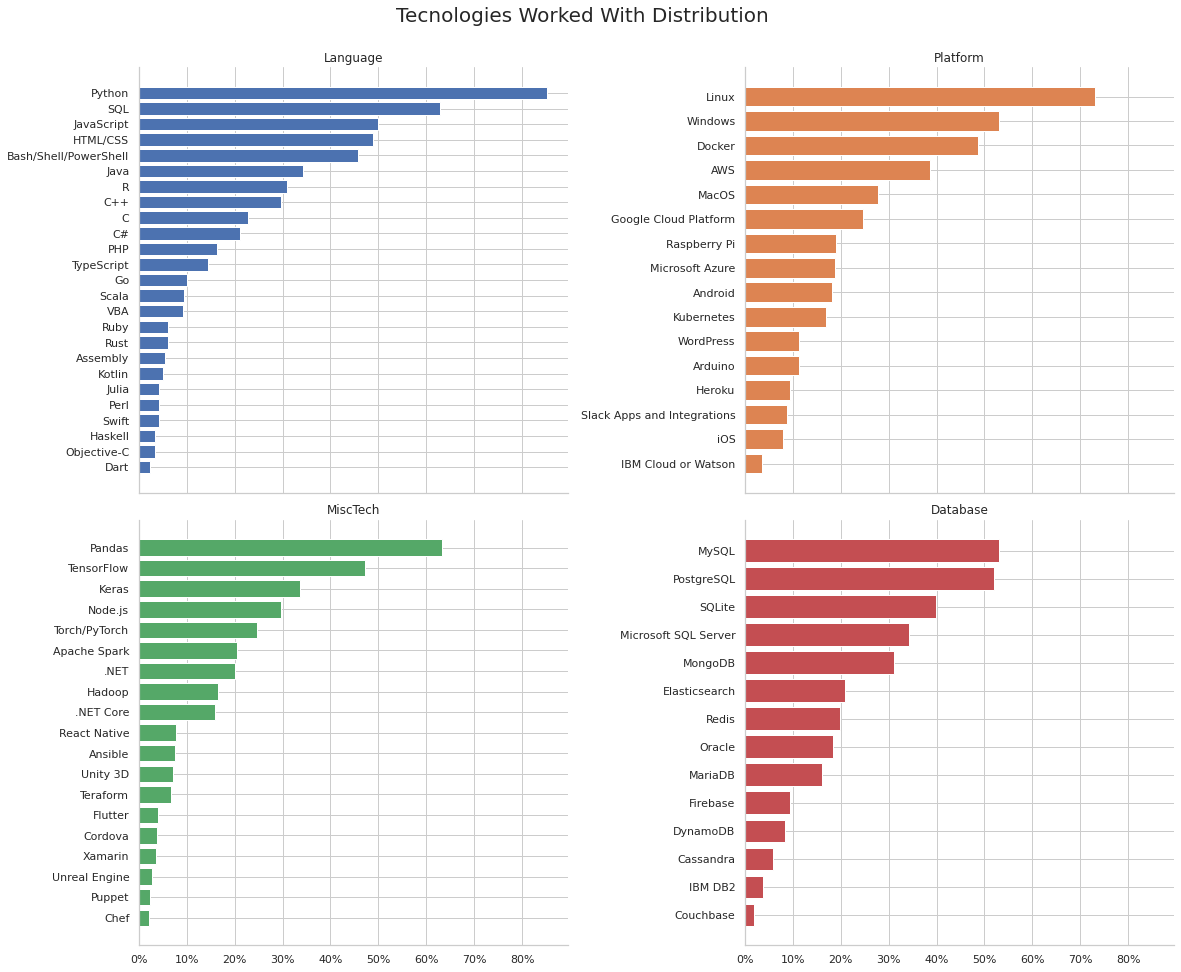

In [13]:
# categorical order for legend and colormap

tech_dist['type'] = pd.Categorical(tech_dist['type'], categories=tech_types, ordered=True)

gs = sns.FacetGrid(data=tech_dist, col='type', sharey=False,
                   col_wrap=2, aspect=1.2, height=7, hue='type',
                   palette=tech_palette)

gs.map(plt.barh, 'tech', 'percent')
gs.set_titles('{col_name}')
for i, ax in enumerate(gs.axes.flat):
        ax.xaxis.set_major_formatter(lambda x, p: f'{x:.0%}')
        ax.set_ylabel('')
        ax.set_xlabel('')
gs.fig.subplots_adjust(top=0.92)
gs.fig.suptitle('Tecnologies Worked With Distribution', fontsize=20)
plt.show()

### 2.3.2 Educational Variables

In [14]:
edu_vars = ['EdLevel', 'UndergradMajor']
edu_dummies = dummify_df(ds_df, edu_vars).reindex(y.index)
edu_dummies.shape

(2601, 21)

In [15]:
edu_dist = edu_dummies.mean()
edu_dist = edu_dist.reset_index()

edu_dist[['type', 'edu']] = edu_dist['index'].str.split('_', expand=True)
edu_dist.drop(columns='index', inplace=True)
edu_dist.rename(columns={0:'percent'}, inplace=True)
edu_dist.sort_values('percent', inplace=True)
edu_dist['type'] = pd.Categorical(edu_dist['type'], categories=edu_vars, ordered=True)

In [96]:
round(edu_dist[edu_dist['type'] == 'EdLevel'].sort_values('percent', ascending=False).head(3)['percent'].sum() * 100, 2)

91.09

The great majority of respondents have at least a graduate degree (91.09%). More than 40% has a Masters. We can say from this distribution that for a developer to be a data scientists, they need to have a higher qualification than the common developer. Despite that almost half respondents are graduated in `Computer science, computer engineering, or software engineering`. We also have some other majors that are relevant in our distribution such as `Mathematics or statistics`.

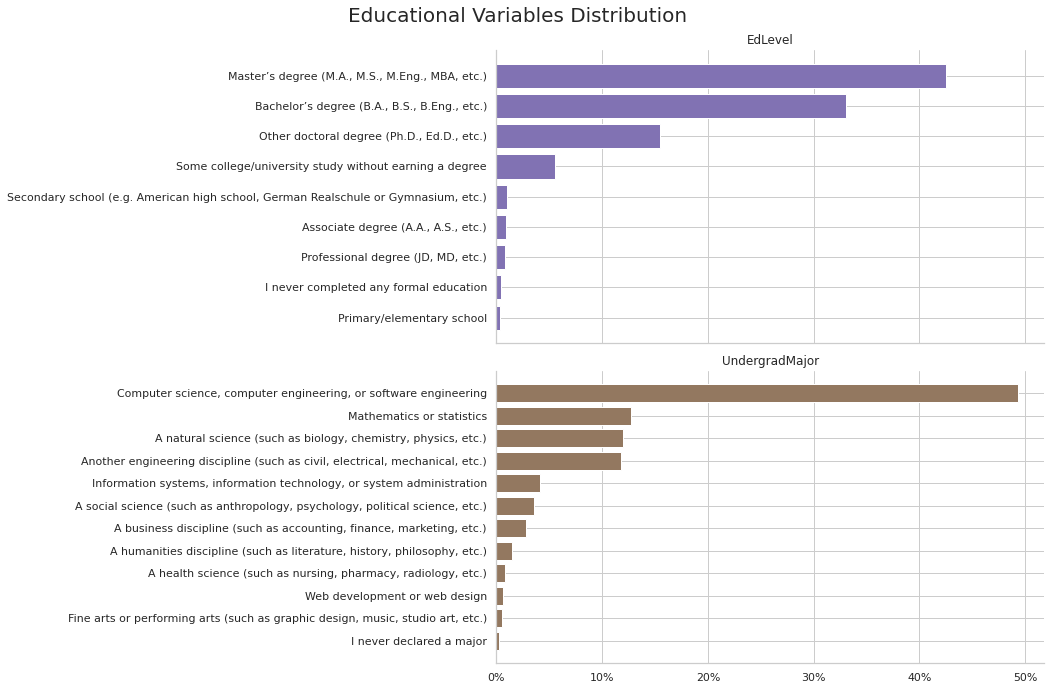

In [16]:
# categorical order for legend and colormap
gs = sns.FacetGrid(data=edu_dist, row='type', sharey=False,
                   aspect=3, height=5, hue='type',
                   palette=educ_palette)
gs.map(plt.barh, 'edu', 'percent')
gs.set_titles('{row_name}')
for i, ax in enumerate(gs.axes.flat):
        ax.xaxis.set_major_formatter(lambda x, p: f'{x:.0%}')
        ax.set_ylabel('')
        ax.set_xlabel('')
gs.fig.subplots_adjust(top=0.92)
gs.fig.suptitle('Educational Variables Distribution', fontsize=20)
plt.show()

# 3.0 Measuring the relationship between technological and educationa variables with compensations levels

Now that we already got a overview of our selected variables let's jump into the main focus of this notebook and start to measure the relationship between technological and educational characteristics with compensations levels of data scientistis professionals.

To do it we will try three approachs. First we will apply the Point-Biserial Correlation Coefficient. Then we will model linear relationship of the features to the compensation with a simple linear regression model for each feature. Finally we will use a multiple linear regression model to consider all features simultaneously to compensation levels determinations.

## 3.1 Point-Biserial Correlation Coefficient

The [Point-biserial correlation coefficient](https://en.wikipedia.org/wiki/Point-biserial_correlation_coefficient) is used when we want to measure the the strength of the association between a continous variable with a dichtomous variable. In our case, each of our dummies variables are dichotmous, while our measures of compensations are continuous.

In [17]:
def biserial_corr(y, cat):
    """Compute the point-biserial correlation coefficent as specified in the wikipedia article:
    https://en.wikipedia.org/wiki/Point-biserial_correlation_coefficient
    
    We are using the sample correction.
    """
    
    n = y.shape[0]
    mu = np.mean(y)
    sum_sqr_dev = np.sum((y-mu)**2)
    sigma_sample = np.sqrt(sum_sqr_dev/(n-1))
    
    g0_select = cat == 0
    n0 = g0_select.sum()
    mu0 = y[g0_select].mean()
    
    g1_select = cat == 1  
    n1 = g1_select.sum()
    mu1 = y[g1_select].mean()
    
    return   ((mu1 - mu0)/sigma_sample) * np.sqrt(n1 * n0 / (n * (n-1)))

### 3.1.1 Technological Variables

In [18]:
corr = [biserial_corr(log_y, tech_dummies[col]) for col in tech_dummies.columns]
data = {'corr': corr, 'tech': tech_dummies.columns}
corr_data = pd.DataFrame(data=data)
corr_data[['type','tech']] = corr_data['tech'].str.split('_', expand=True)
corr_data['type'] = corr_data['type'].str.replace('WorkedWith', '')
corr_data['type'] = pd.Categorical(corr_data['type'], categories=tech_types, ordered=True)
corr_data.sort_values('corr', inplace=True)

Despite being two of the most popular languages, Python and JavaScrip have low correlation levels with the log of the compensation. At the other hand command line languages (bash/shell/powershell) have the highest correlation, followed by scala and julia, two other languages popular with data scientsts, but in our dataset didn't ranked well with our respondents.

Considering the plataforms technologies, MacOS is the one with the highest correlation,followed by three other technologies associated with the deployment of data science application: AWS, Docker and Kubernetes.

As the most positve correlated miscellanous technology we don't see a technoliy used directly for data science, but Teraform a techhnology for infraestructure management. Only than in the second and thir place we have two technologies more used for data science projects, Spark and Hadoop two big data technologies. Keras a technology for deep learning have the second lowest negative correlation.



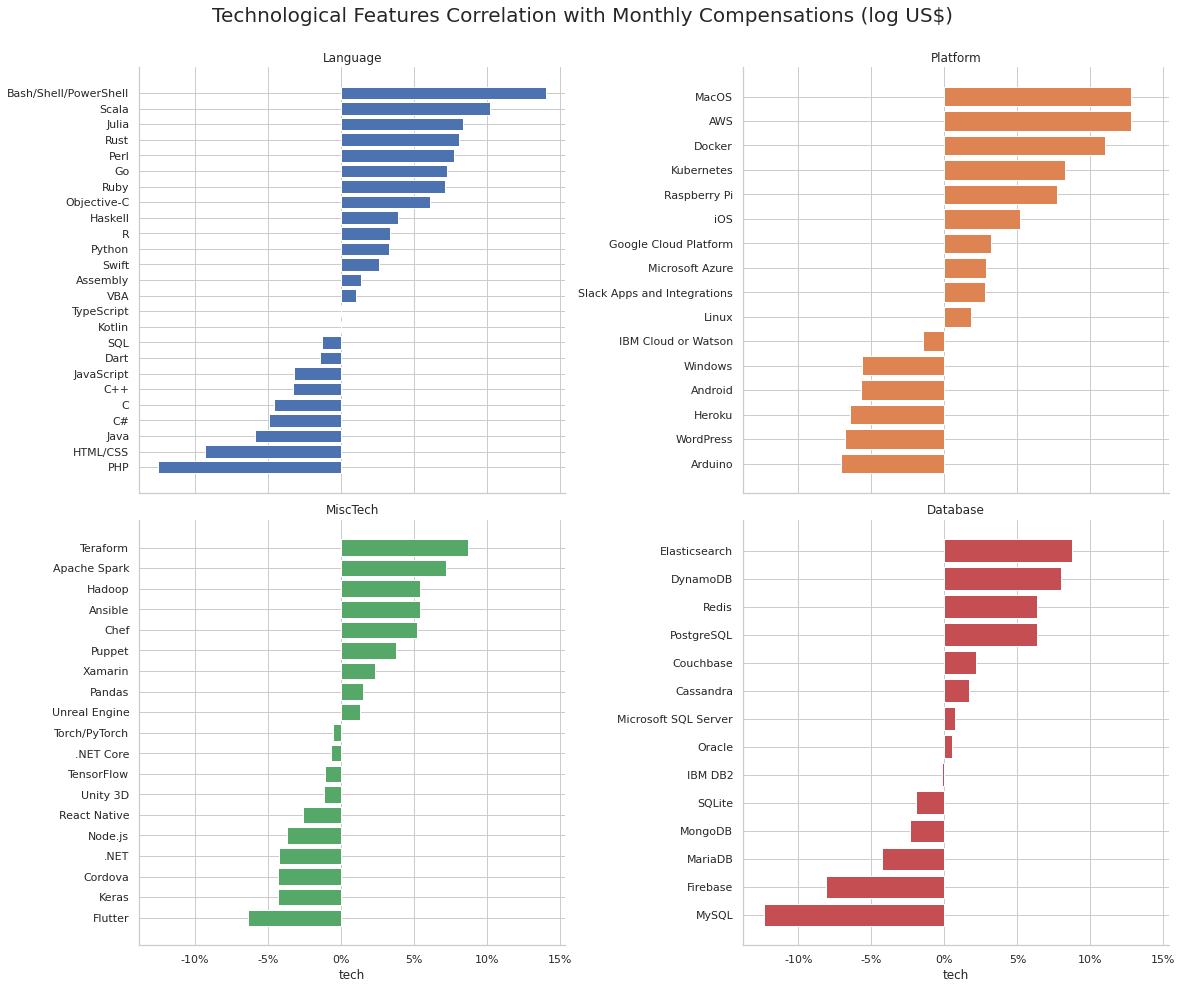

In [19]:
gs = sns.FacetGrid(data=corr_data, col='type', sharey=False,
                   col_wrap=2, aspect=1.2, height=7, hue='type',
                   palette=tech_palette)
gs.map(plt.barh, 'tech', 'corr')
gs.set_titles('{col_name}')
for i, ax in enumerate(gs.axes.flat):
        ax.xaxis.set_major_formatter(lambda x, p: f'{x:.0%}')
        ax.set_ylabel('')
gs.fig.subplots_adjust(top=0.92)
gs.fig.suptitle('Technological Features Correlation with Monthly Compensations (log US$)', fontsize=20)
plt.show()

### 3.1.2 Educational Variables

In [20]:
corr = [biserial_corr(log_y, edu_dummies[col]) for col in edu_dummies.columns]
data = {'corr': corr, 'edu': edu_dummies.columns}
corr_data = pd.DataFrame(data=data)
corr_data[['type','edu']] = corr_data['edu'].str.split('_', expand=True)
#corr_data['type'] = corr_data['type'].str.replace('WorkedWith', '')
corr_data['type'] = pd.Categorical(corr_data['type'], categories=edu_vars, ordered=True)
corr_data.sort_values('corr', inplace=True)

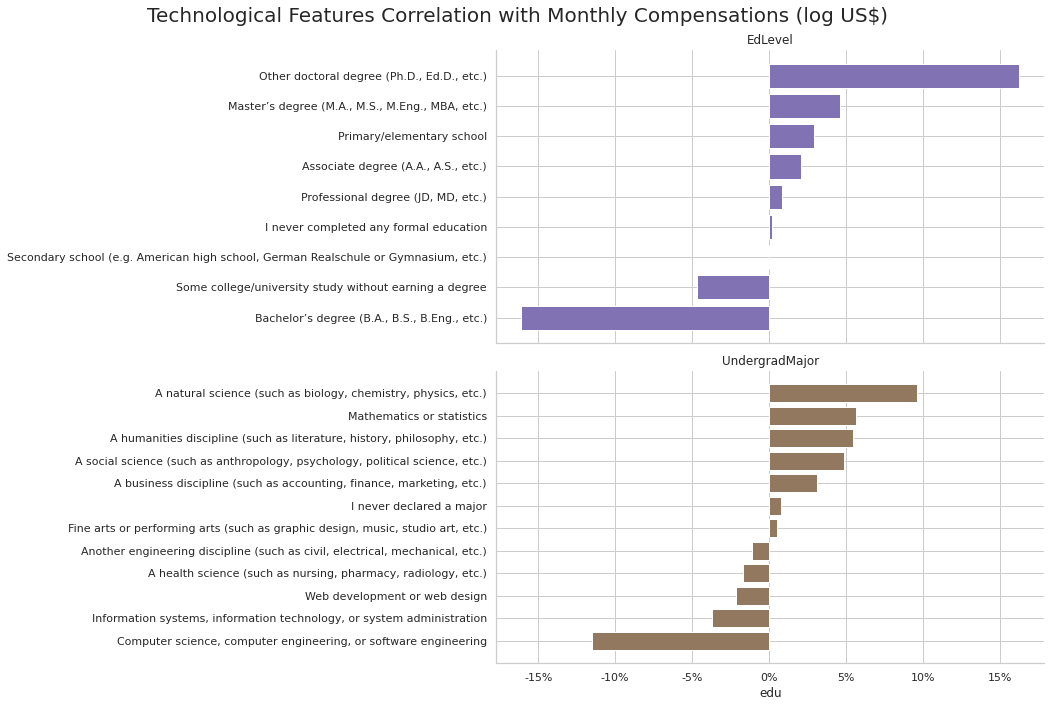

In [21]:
gs = sns.FacetGrid(data=corr_data, row='type', sharey=False,
                   aspect=3, height=5, hue='type',
                   palette=educ_palette)
gs.map(plt.barh, 'edu', 'corr')
gs.set_titles('{row_name}')
for i, ax in enumerate(gs.axes.flat):
        ax.xaxis.set_major_formatter(lambda x, p: f'{x:.0%}')
        ax.set_ylabel('')
gs.fig.subplots_adjust(top=0.92)
gs.fig.suptitle('Technological Features Correlation with Monthly Compensations (log US$)', fontsize=20)
plt.show()

## 3.2 Simple Linear Model

In [22]:
def regression_coef(y, cat):
    x = pd.DataFrame(cat)
    x.fillna(0, inplace=True)
    x['intercept'] = 1
    x = x.reindex(y.index)
    
    lm = sm.OLS(y, x)
    result = lm.fit()
    
    pvalue = result.pvalues[cat.name]
    coef = result.params[cat.name]
    
    return coef, pvalue

### 3.2.1 Tech

In [23]:
coefs = [regression_coef(log_y, tech_dummies[col]) for col in tech_dummies.columns]
coefs_df = pd.DataFrame(coefs)
coefs_df.columns = ['coef', 'pvalue']
coefs_df['tech'] = tech_dummies.columns
coefs_df = coefs_df[coefs_df['pvalue'] < 0.05]

In [24]:
coefs_df[['type','tech']] = coefs_df['tech'].str.split('_', expand=True)
coefs_df['type'] = coefs_df['type'].str.replace('WorkedWith', '')
coefs_df['type'] = pd.Categorical(coefs_df['type'], categories=tech_types, ordered=True)
coefs_df.sort_values('coef', inplace=True)

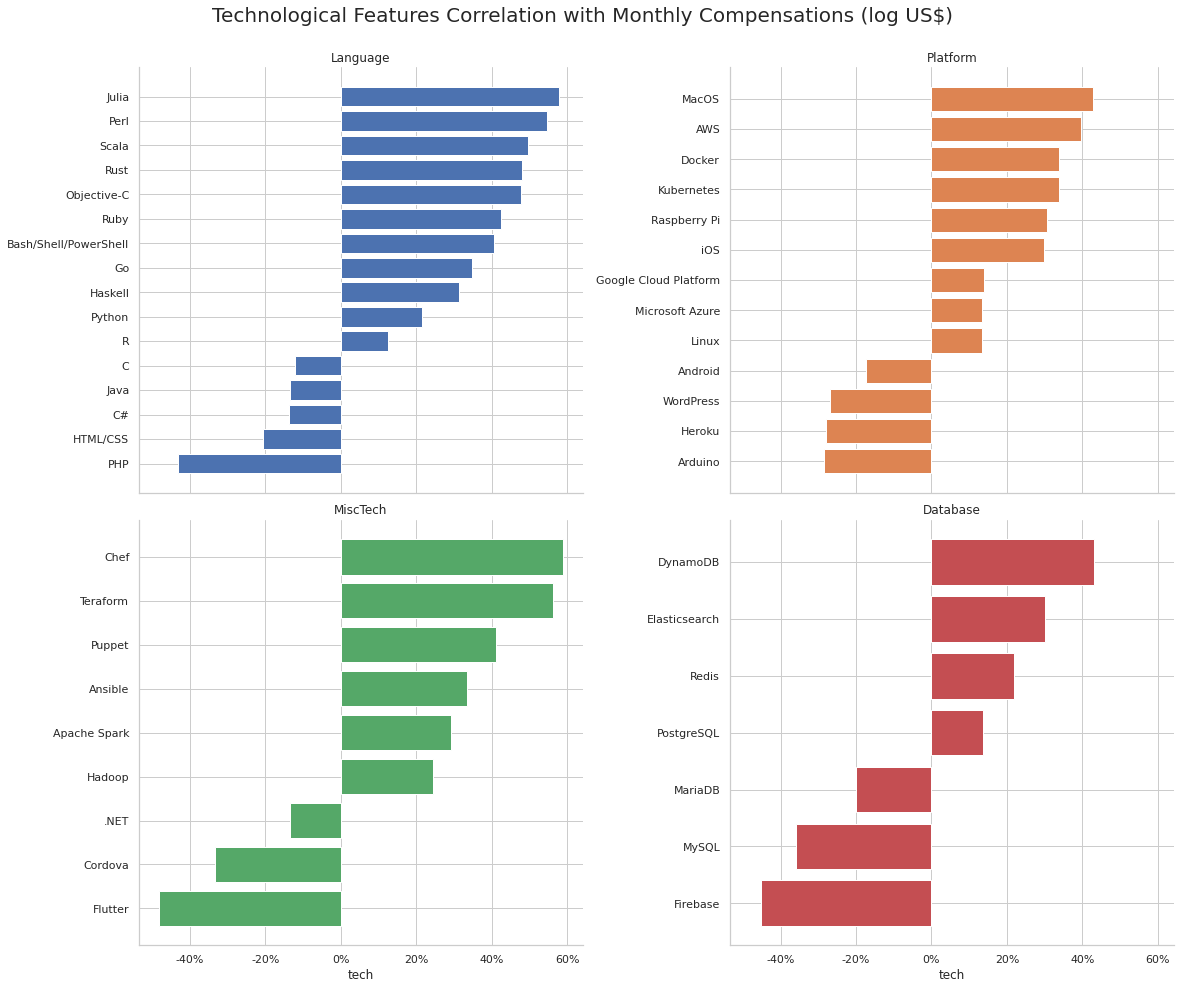

In [25]:
gs = sns.FacetGrid(data=coefs_df, col='type', sharey=False,
                   col_wrap=2, aspect=1.2, height=7, hue='type',
                   palette=tech_palette)
gs.map(plt.barh, 'tech', 'coef')
gs.set_titles('{col_name}')
for i, ax in enumerate(gs.axes.flat):
        ax.xaxis.set_major_formatter(lambda x, p: f'{x:.0%}')
        ax.set_ylabel('')
gs.fig.subplots_adjust(top=0.92)
gs.fig.suptitle('Technological Features Correlation with Monthly Compensations (log US$)', fontsize=20)
plt.show()

### 3.2.2 Edu

In [26]:
coefs = [regression_coef(log_y, edu_dummies[col]) for col in edu_dummies.columns]
coefs_df = pd.DataFrame(coefs)
coefs_df.columns = ['coef', 'pvalue']
coefs_df['edu'] = edu_dummies.columns
coefs_df = coefs_df[coefs_df['pvalue'] < 0.05]
coefs_df

,coef,pvalue,edu
1,-0.437037,7.648836e-16,"EdLevel_Bachelor’s degree (B.A., B.S., B.Eng.,..."
3,0.136189,8.599247e-03,"EdLevel_Master’s degree (M.A., M.S., M.Eng., M..."
4,0.599950,1.771988e-17,"EdLevel_Other doctoral degree (Ph.D., Ed.D., e..."
8,-0.260241,2.093023e-02,EdLevel_Some college/university study without ...
11,0.600326,5.481961e-03,UndergradMajor_A humanities discipline (such a...
12,0.384493,1.716588e-06,UndergradMajor_A natural science (such as biol...
13,0.341607,1.528199e-02,UndergradMajor_A social science (such as anthr...
15,-0.331541,8.849868e-11,"UndergradMajor_Computer science, computer engi..."
18,-0.269879,3.983578e-02,"UndergradMajor_Information systems, informatio..."
19,0.211752,6.958727e-03,UndergradMajor_Mathematics or statistics


In [27]:
coefs_df[['type','edu']] = coefs_df['edu'].str.split('_', expand=True)
coefs_df['type'] = pd.Categorical(coefs_df['type'], categories=edu_vars, ordered=True)
coefs_df.sort_values('coef', inplace=True)


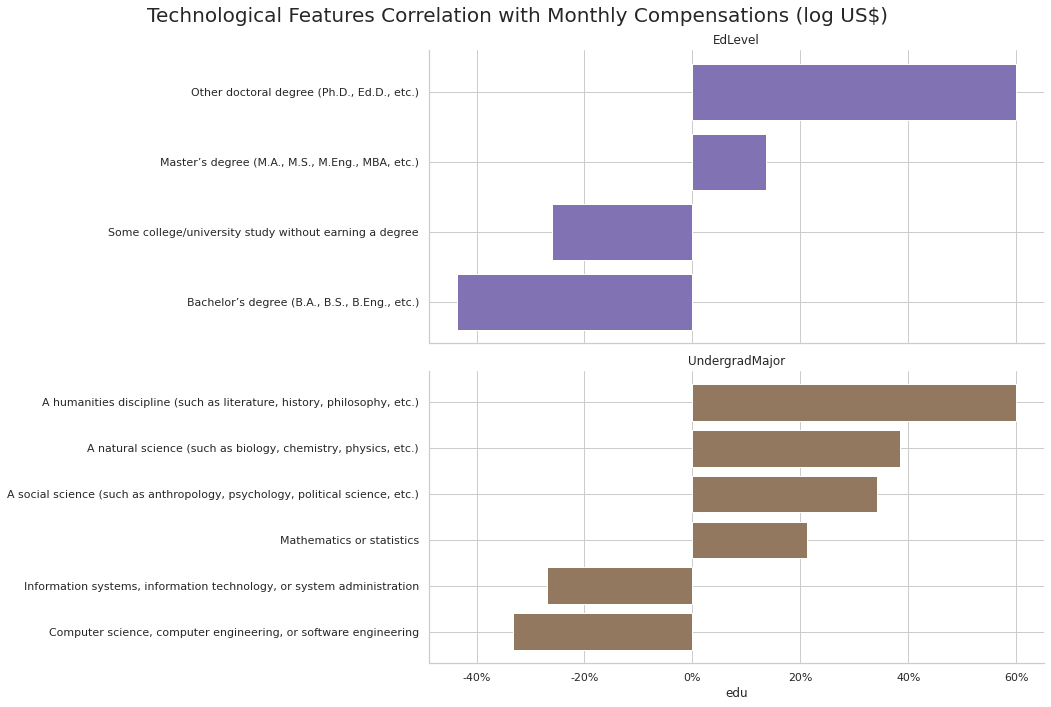

In [28]:
gs = sns.FacetGrid(data=coefs_df, row='type', sharey=False,
                   aspect=3, height=5, hue='type',
                   palette=educ_palette)
gs.map(plt.barh, 'edu', 'coef')
gs.set_titles('{row_name}')
for i, ax in enumerate(gs.axes.flat):
        ax.xaxis.set_major_formatter(lambda x, p: f'{x:.0%}')
        ax.set_ylabel('')
gs.fig.subplots_adjust(top=0.92)
gs.fig.suptitle('Technological Features Correlation with Monthly Compensations (log US$)', fontsize=20)
plt.show()

### 3.2.3 Limitations of the simple linear model

A problem with those simple models is that they don't consider the inter relationship between all the variables. That is their correlation and how it effetcs to their linear coefficient estimates.

To analyze the correlation between binary features we will use the [Jaccard Similarity Index](https://en.wikipedia.org/wiki/Jaccard_index). If those variables are highly correlated our model might suffer from a high multicolinearity in the independent variables that in turn can make our estimates inprecise. for that to not happens we will select eliminate those that correlated with each other. More specifically those variables that are highly correlated with the intercept will be droped from the our set of independent varialbles. Since, we have a high number of features we will use a threshold to select only a subset of variables. A arbitrary value chosed is 0.7.

In [29]:
def jaccard_index(x, y):
    """Implementation of the jaccard index.
    Compute it from two series of binary values
    """
    x_y = ((x == 1) & (y == 1)).sum()
    return x_y / (x.sum() + y.sum() - x_y)

In [30]:
X = edu_dummies.join(tech_dummies)
X.fillna(0, inplace=True)
X['intercept'] = 1
X = X.reindex(log_y.index)

jaccard_matrix = X.corr(jaccard_index)
jaccard_matrix.shape

(96, 96)

In [31]:
jaccard_matrix.mean().sort_values().tail(20) - 1 / jaccard_matrix.shape[0]

LanguageWorkedWith_C++                                                            0.126998
DatabaseWorkedWith_MongoDB                                                        0.133126
UndergradMajor_Computer science, computer engineering, or software engineering    0.137457
MiscTechWorkedWith_Node.js                                                        0.139233
DatabaseWorkedWith_SQLite                                                         0.140284
MiscTechWorkedWith_TensorFlow                                                     0.140374
LanguageWorkedWith_Java                                                           0.143215
MiscTechWorkedWith_Pandas                                                         0.144099
PlatformWorkedWith_Windows                                                        0.144911
PlatformWorkedWith_AWS                                                            0.145210
LanguageWorkedWith_Bash/Shell/PowerShell                                          0.148696

In [32]:
selected_dummies = (jaccard_matrix > .5).sum() > 1
jaccard_matrix.loc[selected_dummies, selected_dummies]

,LanguageWorkedWith_C#,LanguageWorkedWith_Dart,LanguageWorkedWith_HTML/CSS,LanguageWorkedWith_JavaScript,LanguageWorkedWith_Python,LanguageWorkedWith_SQL,PlatformWorkedWith_Docker,PlatformWorkedWith_Linux,MiscTechWorkedWith_.NET,MiscTechWorkedWith_.NET Core,MiscTechWorkedWith_Flutter,MiscTechWorkedWith_Keras,MiscTechWorkedWith_Pandas,MiscTechWorkedWith_TensorFlow,intercept
LanguageWorkedWith_C#,1.000000,0.055357,0.263499,0.265957,0.178729,0.230455,0.156250,0.167515,0.610649,0.534151,0.080279,0.110818,0.126179,0.148858,0.204152
LanguageWorkedWith_Dart,0.055357,1.000000,0.035484,0.037915,0.023732,0.024390,0.033585,0.027057,0.041929,0.054688,0.557895,0.024580,0.019122,0.027384,0.023068
LanguageWorkedWith_HTML/CSS,0.263499,0.035484,1.000000,0.665323,0.440685,0.495996,0.353107,0.430077,0.220426,0.178813,0.055511,0.218692,0.331458,0.292767,0.470588
LanguageWorkedWith_JavaScript,0.265957,0.037915,0.665323,1.000000,0.457278,0.492884,0.382554,0.446523,0.218300,0.180945,0.057526,0.209501,0.341314,0.295119,0.482122
LanguageWorkedWith_Python,0.178729,0.023732,0.440685,0.457278,1.000000,0.566133,0.468944,0.664676,0.143301,0.116352,0.031959,0.329630,0.627660,0.460581,0.822760
LanguageWorkedWith_SQL,0.230455,0.024390,0.495996,0.492884,0.566133,1.000000,0.376565,0.474614,0.195846,0.160531,0.036070,0.241935,0.445259,0.312846,0.606690
PlatformWorkedWith_Docker,0.156250,0.033585,0.353107,0.382554,0.468944,0.376565,1.000000,0.509521,0.122905,0.121302,0.046550,0.296322,0.393443,0.359926,0.450211
PlatformWorkedWith_Linux,0.167515,0.027057,0.430077,0.446523,0.664676,0.474614,0.509521,1.000000,0.137610,0.114225,0.039326,0.303711,0.483003,0.414090,0.677432
MiscTechWorkedWith_.NET,0.610649,0.041929,0.220426,0.218300,0.143301,0.195846,0.122905,0.137610,1.000000,0.576613,0.069246,0.094569,0.094635,0.118321,0.168012
MiscTechWorkedWith_.NET Core,0.534151,0.054688,0.178813,0.180945,0.116352,0.160531,0.121302,0.114225,0.576613,1.000000,0.090680,0.072709,0.084959,0.097522,0.132641


## 3.3 Multiple Linear Regression Model

### 3.3.1 Treating multicolinearity 

In [33]:
def identify_multicolinearity(X, threshold=10):
    """For column in X computes its variance inflation factor and return only.
    those factors from variables that might be causing severe multicolinearity.
    As a rule of thumb a factor above 10 (default threshold) is problematic.
    
    The variance inflation factor is used to quantify the severity of multicolinearity
    in and ols regression analysis. More specificaly, it measures how much the
    variance of coefficient estimates is increased becase of collinearity
    https://en.wikipedia.org/wiki/Variance_inflation_factor
    """
    
    data = [variance_inflation_factor(X.values, i)
            for i in range(X.shape[1])]
    vif = pd.Series(data=data, index=X.columns, name='vif_factor')
    critical_vif = vif[vif > threshold]
    
    return critical_vif

In [34]:
identify_multicolinearity(X)

EdLevel_Bachelor’s degree (B.A., B.S., B.Eng., etc.)        30.689097
EdLevel_Master’s degree (M.A., M.S., M.Eng., MBA, etc.)     33.836105
EdLevel_Other doctoral degree (Ph.D., Ed.D., etc.)          18.741899
intercept                                                  169.187108
Name: vif_factor, dtype: float64

In [35]:
droped_features = ['EdLevel_Bachelor’s degree (B.A., B.S., B.Eng., etc.)']

In [36]:
X_new = X.drop(columns=droped_features)
identify_multicolinearity(X_new, 10)

intercept    44.096885
Name: vif_factor, dtype: float64

In [37]:
X_new.shape

(2601, 95)

### 3.3.2 Fitting the model

In [38]:
lm = sm.OLS(log_y, X_new)
result = lm.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       LogConvertedComp   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     7.083
Date:                Sun, 02 May 2021   Prob (F-statistic):           6.21e-75
Time:                        18:06:45   Log-Likelihood:                -4078.2
No. Observations:                2601   AIC:                             8346.
Df Residuals:                    2506   BIC:                             8903.
Df Model:                          94                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================================================
                                                                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------------------
EdLevel_Associate degree (A.A., A.S., etc.)                                                       0.4391      0.257      1.709      0.088      -0.065       0.943
EdLevel_I never completed any formal education                                                    0.1182      0.409      0.289      0.772      -0.683       0.919
EdLevel_Master’s degree (M.A., M.S., M.Eng., MBA, etc.)                                           0.3231      0.056      5.798      0.000       0.214       0.432
EdLevel_Other doctoral degree (Ph.D., Ed.D., etc.)                                                0.7137      0.079      9.090      0.000       0.560       0.868
EdLevel_Primary/elementary school                                                                 0.2135      0.465      0.459      0.646      -0.699       1.126
EdLevel_Professional degree (JD, MD, etc.)                                                        0.5260      0.268      1.961      0.050     5.8e-05       1.052
EdLevel_Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)       -0.0904      0.274     -0.330      0.741      -0.627       0.446
EdLevel_Some college/university study without earning a degree                                    0.0625      0.112      0.557      0.577      -0.157       0.283
UndergradMajor_A business discipline (such as accounting, finance, marketing, etc.)              -0.0059      0.197     -0.030      0.976      -0.392       0.380
UndergradMajor_A health science (such as nursing, pharmacy, radiology, etc.)                     -0.6129      0.309     -1.983      0.047      -1.219      -0.007
UndergradMajor_A humanities discipline (such as literature, history, philosophy, etc.)            0.0921      0.239      0.385      0.700      -0.377       0.562
UndergradMajor_A natural science (such as biology, chemistry, physics, etc.)                     -0.1666      0.151     -1.106      0.269      -0.462       0.129
UndergradMajor_A social science (such as anthropology, psychology, political science, etc.)      -0.0669      0.185     -0.362      0.717      -0.429       0.295
UndergradMajor_Another engineering discipline (such as civil, electrical, mechanical, etc.)      -0.3434      0.151     -2.268      0.023      -0.640      -0.047
UndergradMajor_Computer science, computer engineering, or software engineering                   -0.4702      0.139     -3.394      0.001      -0.742      -0.199
UndergradMajor_Fine arts or performing arts (such as graphic design, music, studio art, etc.)    -0.2308      0.371     -0.622      0.534      -0.958       0.496
Under

In [40]:
selected_features = result.params.index.str.contains('WorkedWith|UndergradMajor|EdLevel')
selected_coefs = pd.DataFrame(data=np.array([result.params, result.pvalues]).T,
                           columns=['coef', 'pvalues'],
                           index=result.params.index)[selected_features]

significant_coefs = selected_coefs[selected_coefs['pvalues'] <= 0.05].sort_values('coef').reset_index()
significant_coefs.rename(columns={'index': 'dummy'}, inplace=True)
significant_coefs[['variable', 'option']] = significant_coefs['dummy'].str.split('_', expand=True)
significant_coefs['variable'] = significant_coefs['variable'].str.replace('WorkedWith', '')
significant_coefs['variable'] = pd.Categorical(significant_coefs['variable'],
                                               categories=tech_types + edu_vars, ordered=True)

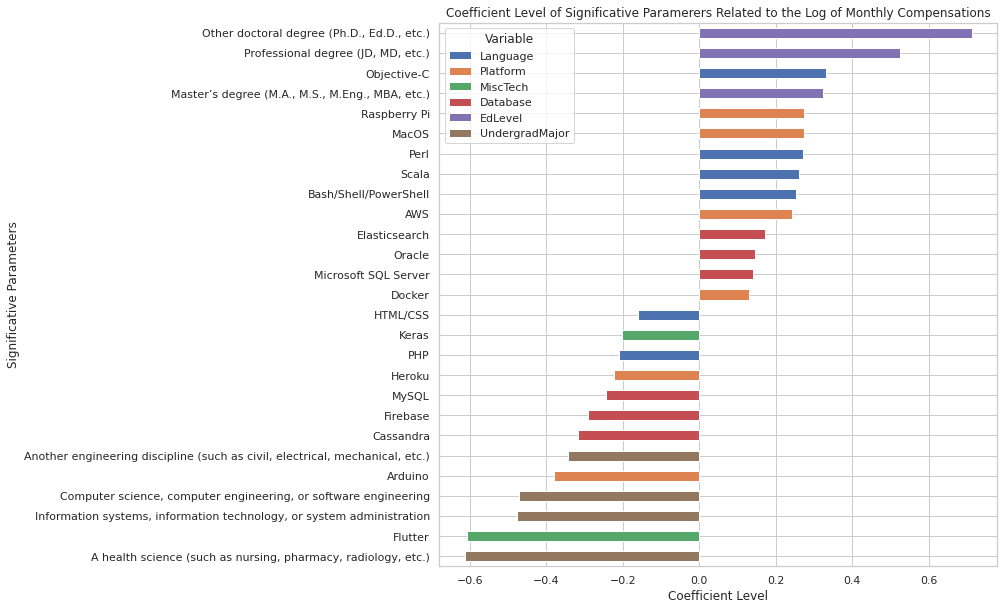

In [46]:
ax = (significant_coefs.pivot(index='option', columns='variable', values='coef').
 reindex(significant_coefs['option']).
 plot(kind='barh', stacked=True, figsize=(10,10)))

plt.xlabel('Coefficient Level')
plt.ylabel('Significative Parameters')
plt.title('Coefficient Level of Significative Paramerers Related to the Log of Monthly Compensations')
plt.legend(title='Variable')
plt.show()